In [1]:
%load_ext autoreload
%autoreload 2
import gc
import re
import pandas as pd
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
pd.set_option('max_columns', 200)
pd.set_option('max_rows', 200)
import os
import sys
HOME = os.path.expanduser("~")
sys.path.append(f'{HOME}/kaggle/data_analysis/library')
import utils
from utils import get_categorical_features, get_numeric_features
import datetime

from tqdm import tqdm
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import time
import sys
import datetime
from sklearn.metrics import mean_squared_error

os.listdir('../input/')
key = 'card_id'
target = 'target'
ignore_list = [key, target, 'merchant_id', 'first_avtive_month']

feat_no = '111_ker_'

### Data Load

In [2]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')
seed = 1208
np.random.seed(seed)

In [18]:
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')
df_hist_trans = pd.read_csv('../input/historical_transactions.csv')
df_new_merchant_trans = pd.read_csv('../input/new_merchant_transactions.csv')

In [4]:
for df in [df_hist_trans,df_new_merchant_trans]:
    df['category_2'].fillna(1.0,inplace=True)
    df['category_3'].fillna('A',inplace=True)
    df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)

In [5]:
def get_new_columns(name,aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

In [6]:
for df in [df_hist_trans,df_new_merchant_trans]:
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0}) 
    #https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/73244
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']

In [7]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']

aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['authorized_flag'] = ['sum', 'mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    df_hist_trans[col+'_mean'] = df_hist_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']    

new_columns = get_new_columns('hist',aggs)
df_hist_trans_group = df_hist_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['hist_purchase_date_diff'] = (df_hist_trans_group['hist_purchase_date_max'] - df_hist_trans_group['hist_purchase_date_min']).dt.days
df_hist_trans_group['hist_purchase_date_average'] = df_hist_trans_group['hist_purchase_date_diff']/df_hist_trans_group['hist_card_id_size']
df_hist_trans_group['hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['hist_purchase_date_max']).dt.days
df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group;gc.collect()

42

In [8]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']
aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['authorized_flag'] = ['sum', 'mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    df_new_merchant_trans[col+'_mean'] = df_new_merchant_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']
    
new_columns = get_new_columns('new_hist',aggs)
df_hist_trans_group = df_new_merchant_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['new_hist_purchase_date_diff'] = (df_hist_trans_group['new_hist_purchase_date_max'] - df_hist_trans_group['new_hist_purchase_date_min']).dt.days
df_hist_trans_group['new_hist_purchase_date_average'] = df_hist_trans_group['new_hist_purchase_date_diff']/df_hist_trans_group['new_hist_card_id_size']
df_hist_trans_group['new_hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['new_hist_purchase_date_max']).dt.days
df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group;gc.collect()

28

In [9]:
del df_hist_trans;gc.collect()
del df_new_merchant_trans;gc.collect()
df_train.head(5)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,hist_month_nunique,hist_hour_nunique,hist_weekofyear_nunique,hist_dayofweek_nunique,hist_year_nunique,hist_subsector_id_nunique,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_mean,hist_purchase_amount_var,hist_installments_sum,hist_installments_max,hist_installments_min,hist_installments_mean,hist_installments_var,hist_purchase_date_max,hist_purchase_date_min,hist_month_lag_max,hist_month_lag_min,hist_month_lag_mean,hist_month_lag_var,hist_month_diff_mean,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_weekend_sum,hist_weekend_mean,hist_category_1_sum,hist_category_1_mean,hist_card_id_size,hist_category_2_mean_mean,hist_category_3_mean_mean,hist_purchase_date_diff,hist_purchase_date_average,hist_purchase_date_uptonow,new_hist_month_nunique,new_hist_hour_nunique,new_hist_weekofyear_nunique,new_hist_dayofweek_nunique,new_hist_year_nunique,new_hist_subsector_id_nunique,new_hist_merchant_id_nunique,new_hist_merchant_category_id_nunique,new_hist_purchase_amount_sum,new_hist_purchase_amount_max,new_hist_purchase_amount_min,new_hist_purchase_amount_mean,new_hist_purchase_amount_var,new_hist_installments_sum,new_hist_installments_max,new_hist_installments_min,new_hist_installments_mean,new_hist_installments_var,new_hist_purchase_date_max,new_hist_purchase_date_min,new_hist_month_lag_max,new_hist_month_lag_min,new_hist_month_lag_mean,new_hist_month_lag_var,new_hist_month_diff_mean,new_hist_weekend_sum,new_hist_weekend_mean,new_hist_category_1_sum,new_hist_category_1_mean,new_hist_card_id_size,new_hist_category_2_mean_mean,new_hist_category_3_mean_mean,new_hist_purchase_date_diff,new_hist_purchase_date_average,new_hist_purchase_date_uptonow
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283,9,23,35,7,2,21,94,41,-165.968739,2.258395,-0.739395,-0.638341,0.045003,4,1,0,0.015385,0.015206,2018-02-25 09:31:15,2017-06-27 14:18:08,0,-8,-3.911538,5.748901,10.165385,247,0.950000,90,0.346154,0,0.000000,260,0.072502,0.346719,242,0.930769,307,2.0,8.0,7.0,7.0,1.0,10.0,23.0,14.0,-13.244202,-0.296112,-0.724368,-0.575835,0.018445,0.0,0.0,0.0,0.000000,0.000000,2018-04-29 11:23:05,2018-03-05 14:04:36,2.0,1.0,1.478261,0.260870,10.000000,6.0,0.260870,0.0,0.000000,23.0,-0.550160,-0.592993,54.0,2.347826,244.0
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913,12,24,50,7,2,24,142,57,-210.006336,4.630299,-0.742400,-0.600018,0.148200,543,10,-1,1.551429,2.282448,2018-01-31 22:31:09,2017-01-06 16:29:42,0,-12,-5.031429,14.477519,11.162857,339,0.968571,132,0.377143,31,0.088571,350,0.074568,-0.295163,390,1.114286,331,2.0,5.0,4.0,4.0,1.0,4.0,6.0,5.0,-4.355735,-0.701858,-0.739410,-0.725956,0.000205,6.0,1.0,1.0,1.000000,0.000000,2018-03-30 06:48:26,2018-02-01 17:07:54,2.0,1.0,1.500000,0.300000,11.166667,0.0,0.000000,0.0,0.000000,6.0,-0.550160,-0.606486,56.0,9.333333,274.0
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056,10,14,22,7,2,7,13,8,-29.167391,-0.145847,-0.730138,-0.678311,0.007635,0,0,0,0.000000,0.000000,2018-02-27 19:08:25,2017-01-11 08:21:22,0,-13,-8.604651,14.768549,10.093023,41,0.953488,11,0.255814,0,0.000000,43,-0.087803,0.358458,412,9.581395,305,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-0.700326,-0.700326,-0.700326,-0.700326,NaN,0.0,0.0,0.0,0.000000,NaN,2018-04-28 17:43:11,2018-04-28 17:43:11,2.0,2.0,2.000000,NaN,10.000000,1.0,1.000000,0.0,0.000000,1.0,-0.549015,-0.592993,0.0,0.000000,245.0
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495,6,16,20,7,2,13,50,25,-49.491364,1.445596,-0.740897,-0.642745,0.068447,84,3,-1,1.090909,0.346890,2018-02-28 11:44:40,2017-09-26 16:22:21,0,-5,-2.831169,3.247437,10.116883,77,1.000000,11,0.142857,12,0.155844,77,-0.086166,-0.338321,154,2.000000,304,2.0,5.0,5.0,4.0,1.0,5.0,7.0,6.0,-4.654372,-0.566740,-0.734135,-0.664910,0.004340,5.0,1.0,-1.0,0.714286,0.571429,2018-04-18 11:00:11,2018-03-07 11:55:06,2.0,1.0,1.714286,0.238095,10.000000,3.0,0.428571,1.0,0.142857,7.0,-0.556518,-0.604559,41.0,5.8

In [10]:
df_train['outliers'] = 0
df_train.loc[df_train['target'] < -30, 'outliers'] = 1
df_train['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

In [11]:
for df in [df_train,df_test]:
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_hist_first_buy'] = (df['new_hist_purchase_date_min'] - df['first_active_month']).dt.days
    for f in ['hist_purchase_date_max','hist_purchase_date_min','new_hist_purchase_date_max',\
                     'new_hist_purchase_date_min']:
        df[f] = df[f].astype(np.int64) * 1e-9
    df['card_id_total'] = df['new_hist_card_id_size'].fillna(0)+df['hist_card_id_size'].fillna(0)
    df['purchase_amount_total'] = df['new_hist_purchase_amount_sum']+df['hist_purchase_amount_sum']

for f in ['feature_1','feature_2','feature_3']:
    order_label = df_train.groupby([f])['outliers'].mean()
    df_train[f] = df_train[f].map(order_label)
    df_test[f] = df_test[f].map(order_label)

In [12]:
df_train_columns = [c for c in df_train.columns if c not in ['card_id', 'first_active_month','target','outliers']]
target = df_train['target']
del df_train['target']

In [15]:
id_list = pd.read_csv('../output/1229_elo_id_list_std001_max-5.csv')[key].values
train = df_train.loc[df_train.card_id.isin(id_list), :]
display(train.head())
display(train.tail())

,first_active_month,card_id,feature_1,feature_2,feature_3,hist_month_nunique,hist_hour_nunique,hist_weekofyear_nunique,hist_dayofweek_nunique,hist_year_nunique,hist_subsector_id_nunique,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_mean,hist_purchase_amount_var,hist_installments_sum,hist_installments_max,hist_installments_min,hist_installments_mean,hist_installments_var,hist_purchase_date_max,hist_purchase_date_min,hist_month_lag_max,hist_month_lag_min,hist_month_lag_mean,hist_month_lag_var,hist_month_diff_mean,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_weekend_sum,hist_weekend_mean,hist_category_1_sum,hist_category_1_mean,hist_card_id_size,hist_category_2_mean_mean,hist_category_3_mean_mean,hist_purchase_date_diff,hist_purchase_date_average,hist_purchase_date_uptonow,new_hist_month_nunique,new_hist_hour_nunique,new_hist_weekofyear_nunique,new_hist_dayofweek_nunique,new_hist_year_nunique,new_hist_subsector_id_nunique,new_hist_merchant_id_nunique,new_hist_merchant_category_id_nunique,new_hist_purchase_amount_sum,new_hist_purchase_amount_max,new_hist_purchase_amount_min,new_hist_purchase_amount_mean,new_hist_purchase_amount_var,new_hist_installments_sum,new_hist_installments_max,new_hist_installments_min,new_hist_installments_mean,new_hist_installments_var,new_hist_purchase_date_max,new_hist_purchase_date_min,new_hist_month_lag_max,new_hist_month_lag_min,new_hist_month_lag_mean,new_hist_month_lag_var,new_hist_month_diff_mean,new_hist_weekend_sum,new_hist_weekend_mean,new_hist_category_1_sum,new_hist_category_1_mean,new_hist_card_id_size,new_hist_category_2_mean_mean,new_hist_category_3_mean_mean,new_hist_purchase_date_diff,new_hist_purchase_date_average,new_hist_purchase_date_uptonow,outliers,dayofweek,weekofyear,month,elapsed_time,hist_first_buy,new_hist_first_buy,card_id_total,purchase_amount_total
366,2016-06-01,C_ID_e983fee8a2,0.013145,0.011385,0.011428,8,19,21,7,1,12,27,20,-81.241843,1.507069,-0.736014,-0.507762,0.128267,947,12,1,5.918750,22.263797,1.511920e+09,1.483791e+09,0,-10,-3.187500,7.662736,13.112500,72,0.450000,41,0.256250,81,0.506250,160,0.074568,-0.059915,325,2.031250,395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.223372e+09,-9.223372e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,22,6,941,220,NaN,160.0,NaN
408,2016-10-01,C_ID_a1f2b29b82,0.010610,0.011385,0.010283,12,19,41,7,1,12,30,23,-109.325356,-0.293738,-0.745405,-0.666618,0.004051,187,4,1,1.140244,0.244015,1.514702e+09,1.483872e+09,0,-11,-4.573171,10.221607,12.140244,127,0.774390,54,0.329268,25,0.152439,164,-0.072800,-0.357857,356,2.170732,363,1.0,2.0,2.0,2.0,1.0,3.0,3.0,3.0,-2.074425,-0.665765,-0.718282,-0.691475,0.000690,3.0,1.0,1.0,1.000000,0.000000,1.516979e+09,1.516530e+09,1.0,1.0,1.0,0.0,12.0,2.0,0.666667,0.0,0.0,3.0,-0.549015,-0.606486,5.0,1.666667,337.0,0,5,39,10,819,99,477.0,167.0,-111.399781
660,2016-05-01,C_ID_d9464ad421,0.013145,0.011385,0.011428,9,21,22,7,1,18,76,29,-56.447182,1.245908,-0.737141,-0.570174,0.065221,134,12,1,1.353535,2.006390,1.513857e+09,1.483532e+09,0,-11,-2.535354,9.516595,12.121212,85,0.858586,14,0.141414,18,0.181818,99,0.057783,-0.358140,350,3.535354,373,1.0,6.0,2.0,5.0,1.0,6.0,8.0,6.0,0.363025,4.512371,-0.705014,0.045378,3.270123,8.0,1.0,1.0,1.000000,0.000000,1.515833e+09,1.515252e+09,1.0,1.0,1.0,0.0,12.0,3.0,0.375000,0.0,0.0,8.0,-0.550845,-0.606486,6.0,0.750000,350.0,0,6,17,5,972,248,615.0,107.0,-56.084156
1627,2016-08-01,C_ID_74ef1948a8,0.010479,0.008752,0.011428,8,19,27,7,1,12,37,18,-124.232287,-0.386272,-0.742400,-0.694035,0.002640,207,12,0,1.156425,1.683259,1.504166e+09,1.483349e+09,0,-7,-4.553073,3.653066,16.497207,65,0.363128,36,0.201117,111,0.620112,179,0.007559,-0.376096,240,1.340782,485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.223372e+09,-9.223372e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

,first_active_month,card_id,feature_1,feature_2,feature_3,hist_month_nunique,hist_hour_nunique,hist_weekofyear_nunique,hist_dayofweek_nunique,hist_year_nunique,hist_subsector_id_nunique,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_mean,hist_purchase_amount_var,hist_installments_sum,hist_installments_max,hist_installments_min,hist_installments_mean,hist_installments_var,hist_purchase_date_max,hist_purchase_date_min,hist_month_lag_max,hist_month_lag_min,hist_month_lag_mean,hist_month_lag_var,hist_month_diff_mean,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_weekend_sum,hist_weekend_mean,hist_category_1_sum,hist_category_1_mean,hist_card_id_size,hist_category_2_mean_mean,hist_category_3_mean_mean,hist_purchase_date_diff,hist_purchase_date_average,hist_purchase_date_uptonow,new_hist_month_nunique,new_hist_hour_nunique,new_hist_weekofyear_nunique,new_hist_dayofweek_nunique,new_hist_year_nunique,new_hist_subsector_id_nunique,new_hist_merchant_id_nunique,new_hist_merchant_category_id_nunique,new_hist_purchase_amount_sum,new_hist_purchase_amount_max,new_hist_purchase_amount_min,new_hist_purchase_amount_mean,new_hist_purchase_amount_var,new_hist_installments_sum,new_hist_installments_max,new_hist_installments_min,new_hist_installments_mean,new_hist_installments_var,new_hist_purchase_date_max,new_hist_purchase_date_min,new_hist_month_lag_max,new_hist_month_lag_min,new_hist_month_lag_mean,new_hist_month_lag_var,new_hist_month_diff_mean,new_hist_weekend_sum,new_hist_weekend_mean,new_hist_category_1_sum,new_hist_category_1_mean,new_hist_card_id_size,new_hist_category_2_mean_mean,new_hist_category_3_mean_mean,new_hist_purchase_date_diff,new_hist_purchase_date_average,new_hist_purchase_date_uptonow,outliers,dayofweek,weekofyear,month,elapsed_time,hist_first_buy,new_hist_first_buy,card_id_total,purchase_amount_total
199676,2014-04-01,C_ID_d11e626f4b,0.010479,0.014166,0.011428,9,19,22,7,1,6,14,10,-38.943895,-0.266059,-0.731881,-0.660066,0.010593,80,5,1,1.355932,0.681473,1.506504e+09,1.484490e+09,0,-8,-3.576271,7.282876,15.186441,21,0.355932,12,0.203390,16,0.271186,59,0.034025,-0.300710,254,4.305085,458,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.223372e+09,-9.223372e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,14,4,1733,1020,NaN,59.0,NaN
199767,2016-10-01,C_ID_664eb73bf1,0.010610,0.011385,0.010283,6,19,18,7,1,14,30,19,-35.310890,-0.300470,-0.742400,-0.653905,0.009252,71,4,1,1.314815,0.483927,1.498155e+09,1.483314e+09,-1,-6,-3.481481,2.443047,17.111111,48,0.888889,15,0.277778,15,0.277778,54,0.074568,-0.300549,171,3.166667,555,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-0.727509,-0.727509,-0.727509,-0.727509,NaN,1.0,1.0,1.0,1.0,NaN,1.502063e+09,1.502063e+09,1.0,1.0,1.0,NaN,17.00,1.0,1.00,1.0,1.0,1.0,-0.550160,-0.606486,0.0,0.0,509.0,1,5,39,10,819,92,309.0,55.0,-36.038399
200029,2015-06-01,C_ID_277be25179,0.013145,0.011385,0.011428,9,17,27,7,1,13,27,19,-31.015637,0.274895,-0.726923,-0.544134,0.055662,83,6,1,1.456140,0.895363,1.509138e+09,1.483247e+09,0,-9,-4.157895,11.778195,14.228070,35,0.614035,6,0.105263,15,0.263158,57,0.068286,-0.270193,299,5.245614,427,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-0.596643,-0.596643,-0.596643,-0.596643,NaN,1.0,1.0,1.0,1.0,NaN,1.509572e+09,1.509572e+09,1.0,1.0,1.0,NaN,15.00,0.0,0.00,0.0,0.0,1.0,-0.550160,-0.606486,0.0,0.0,422.0,1,0,23,6,1307,580,884.0,58.0,-31.612280
200534,2016-12-01,C_ID_d24bbfba24,0.010712,0.011385,0.010283,11,24,48,7,1,24,188,55,-269.606501,3.054800,-0.745405,-0.546869,0.242335,618,12,1,1.253550,1.852249,1.512086e+09,1.483299e+09,0,-10,-4.596349,11.964783,13.223124,480,0.973631,177,0.359026,74,0.150101,493,0.049337,-0.366237,333,0.675456,393,1.0,3.0,3.0,3.0,1.0,3.0,4.0,3.0,-2.644561,-0.476386,-0.731160,-0.661140,0.015262,4.0,1.0,1.0,1.0,0.0,1.514387e+09,1.512227e+09,1.0,1.0,1.0,0.0,13.25,1.0,0.25,0.0,0.0,4.0,-0.557578,-0.606486,24.0,6.0,367.

In [13]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": -1,
         "random_state": seed}
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.66581	valid_1's rmse: 3.72014
[200]	training's rmse: 3.5901	valid_1's rmse: 3.6886
[300]	training's rmse: 3.54273	valid_1's rmse: 3.67745
[400]	training's rmse: 3.50653	valid_1's rmse: 3.67156
[500]	training's rmse: 3.4774	valid_1's rmse: 3.66799
[600]	training's rmse: 3.45236	valid_1's rmse: 3.66525
[700]	training's rmse: 3.43053	valid_1's rmse: 3.66377
[800]	training's rmse: 3.40925	valid_1's rmse: 3.66242
[900]	training's rmse: 3.3899	valid_1's rmse: 3.66152
[1000]	training's rmse: 3.37268	valid_1's rmse: 3.66092
Early stopping, best iteration is:
[990]	training's rmse: 3.3747	valid_1's rmse: 3.66081
fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.66771	valid_1's rmse: 3.71377
[200]	training's rmse: 3.59054	valid_1's rmse: 3.68312
[300]	training's rmse: 3.54242	valid_1's rmse: 3.67155
[400]	training's rmse: 3.50608	valid_1's rmse: 3.6641
[500]

3.6568631565484204

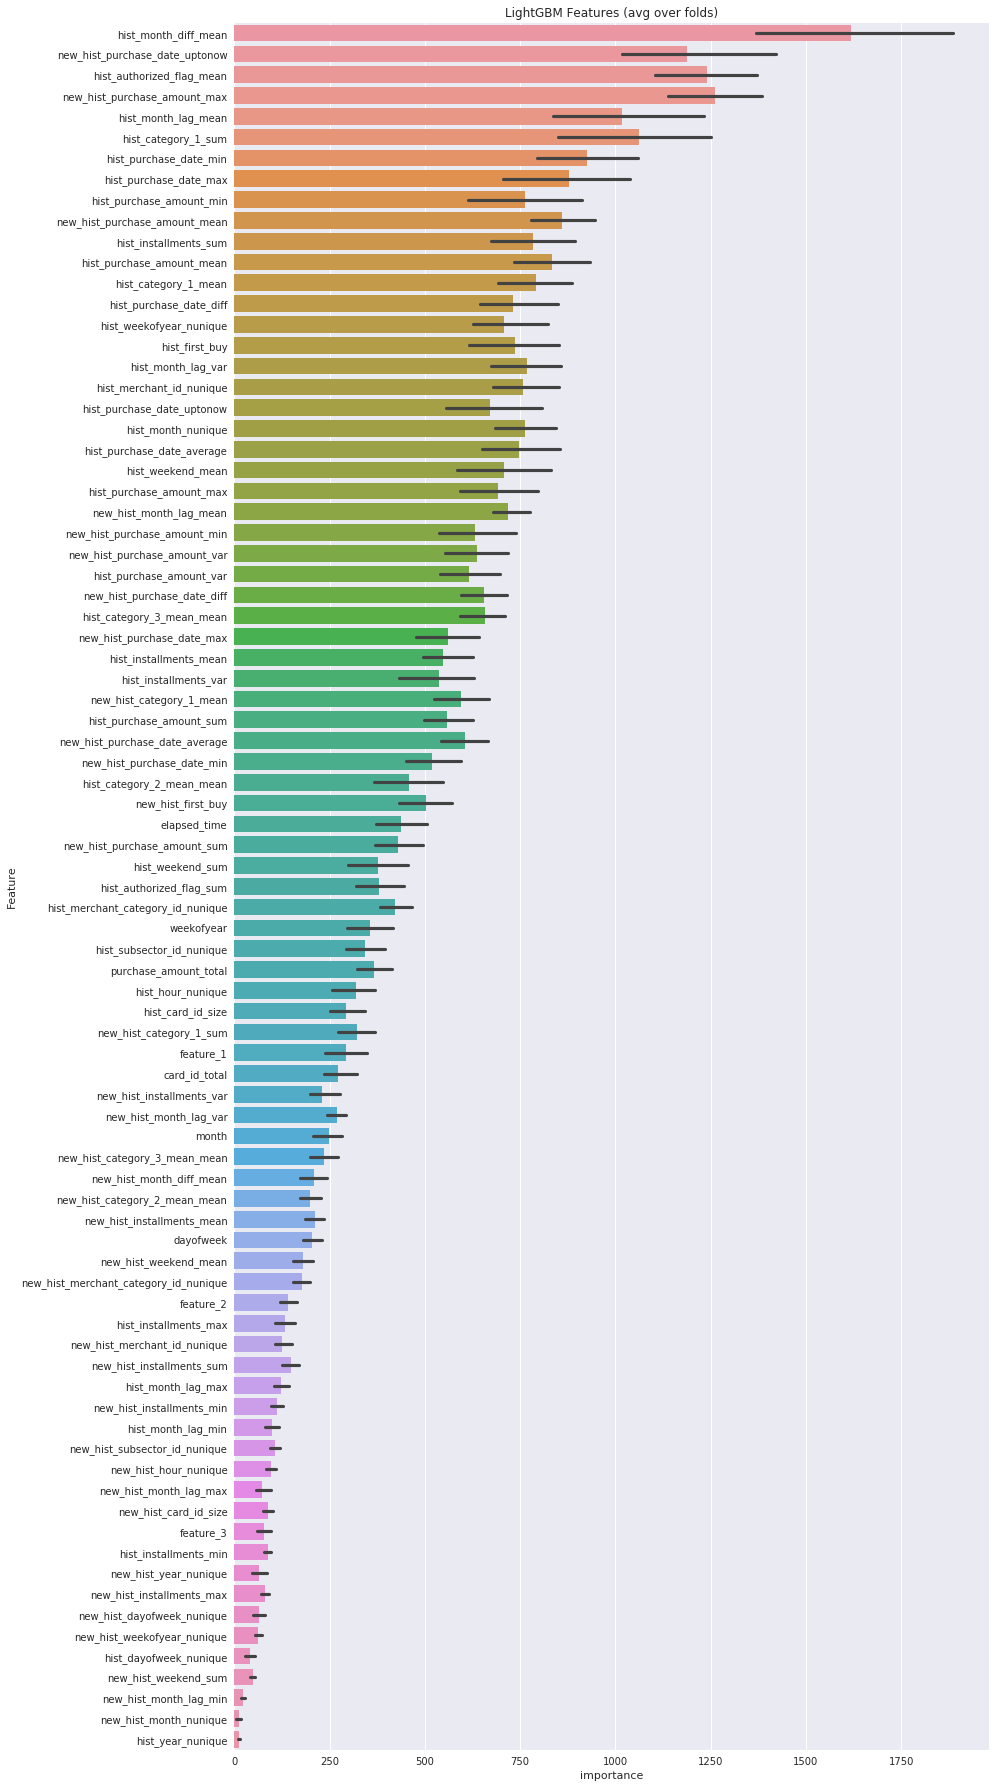

In [14]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [33]:
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("../submit/1213_kernel_LB3699_submission_postpro_less_than_-10.csv", index=False)

In [19]:
sub_df = pd.read_csv('../submit/1213_082_submit_lgb_rate0.01_84features_CV3.6548233901685974_LB.csv')
print(sub_df['target'][sub_df['target']<-12].shape)
# sub_df['target'][sub_df['target']<-12] = -33.21928095
sub_df.sort_values(by='target', ascending=True)

SystemExit: 

In [22]:
df_train_columns

['feature_1',
 'feature_2',
 'feature_3',
 'hist_month_nunique',
 'hist_hour_nunique',
 'hist_weekofyear_nunique',
 'hist_dayofweek_nunique',
 'hist_year_nunique',
 'hist_subsector_id_nunique',
 'hist_merchant_id_nunique',
 'hist_merchant_category_id_nunique',
 'hist_purchase_amount_sum',
 'hist_purchase_amount_max',
 'hist_purchase_amount_min',
 'hist_purchase_amount_mean',
 'hist_purchase_amount_var',
 'hist_installments_sum',
 'hist_installments_max',
 'hist_installments_min',
 'hist_installments_mean',
 'hist_installments_var',
 'hist_purchase_date_max',
 'hist_purchase_date_min',
 'hist_month_lag_max',
 'hist_month_lag_min',
 'hist_month_lag_mean',
 'hist_month_lag_var',
 'hist_month_diff_mean',
 'hist_authorized_flag_sum',
 'hist_authorized_flag_mean',
 'hist_weekend_sum',
 'hist_weekend_mean',
 'hist_category_1_sum',
 'hist_category_1_mean',
 'hist_card_id_size',
 'hist_category_2_mean_mean',
 'hist_category_3_mean_mean',
 'hist_purchase_date_diff',
 'hist_purchase_date_average'

In [23]:
import sys
sys.path.append('../../data_analysis/library/')
import utils

ignore_features = ['first_active_month', 'card_id']

for col in df_train_columns:
#     if col in ignore_features:
#         continue
#     if not(col.count('feature_')):continue
    if not(col.count('card_id_total')):continue
    utils.to_pkl_gzip(path = f'../features/1_first_valid/111_ker_train_{col}@', obj=df_train[col].values)
    utils.to_pkl_gzip(path = f'../features/1_first_valid/111_ker_test_{col}@', obj=df_test[col].values)